In [2]:

from BDDData import *

In [3]:
import importlib
import sys
import csv
sys.path.append('..')
import numpy as np
import torch
import torch.utils.data as data
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx
import matplotlib.pyplot as pltk
from scipy.linalg import circulant
from product_graph import *
from utils import *

In [22]:
import BDDData
importlib.reload(BDDData)

<module 'BDDData' from '/Users/luca/Desktop/TUDelft/Y1/CS4350 ML For Graph Data/Project/ML4GD-WPF/BDDData.py'>

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#Load dataframes
bdd_data = BDD_dataset("raw_data/BDDdata/")
print(f"Initial data shape: {bdd_data.historic_df.shape}")

#Add column with the timestep
bdd_data.add_timestep_id()
#Add flags for chaotic values
bdd_data.tag_chaotic(replace=True)
#Compute the mod for the nazelle and wind angles
bdd_data.angle_mod()
#Interpolate the missing values
bdd_data.interpolate_power()
#Values smaller than 0 are set to 0
bdd_data.cap_power_to_zero()
#Normalize Patv feature to [0,1]
bdd_data.normalize_power(min=0, max=1, method= "MinMaxScaler")
#Convert df to matrix form, where only Patv is included. Then split into train, validation and test
#The matrix contains the subset of the time series for ALL nodes, so an (TxN matrix)
train, val, test = bdd_data.split_df()
print(f"Train shape: {train.shape}, Val shape: {val.shape}, Test shape: {test.shape}")


Initial data shape: (4727520, 15)
Train shape: (134, 24624), Val shape: (134, 3600), Test shape: (134, 7056)


In [6]:
# set seed
np.random.seed(42)
# consider a p percentage of the data
p = 0.01
train_mask = np.random.choice(train.shape[1], int(train.shape[1] * p), replace=False)
val_mask = np.random.choice(val.shape[1], int(val.shape[1] * p), replace=False)
test_mask = np.random.choice(test.shape[1], int(test.shape[1] * p), replace=False)

train = train[:, train_mask]
val = val[:, val_mask]
test = test[:, test_mask]

print(f"Masked Train shape: {train.shape}, Masked Val shape: {val.shape}, Masked Test shape: {test.shape}")


Masked Train shape: (134, 246), Masked Val shape: (134, 36), Masked Test shape: (134, 70)


In [7]:
class CustomBDD_Dataset(data.Dataset):
    def __init__(self, dataset, observation_window=12, forecast_window=12, starting_turbine = 0,  ending_turbine=133):
        self.observation_window = observation_window
        self.forecast_window = forecast_window
        length = eval(f'len({dataset}[0])')#Retrieves length of dataset
        bdd_data.get_observation_forecasting_window(time_series_len=length, observation_steps=self.observation_window, forecast_steps=self.forecast_window)#Generates obs window
        self.window_of_interest =  bdd_data.sliding_indices[str(self.observation_window)+","+str(self.forecast_window)]#Retrieves windows
        self.starting_turbine = starting_turbine
        self.ending_turbine = ending_turbine
        self.dataset = dataset

    def __len__(self):
        return len(self.window_of_interest)

    def __getitem__(self, idx):
        window = self.window_of_interest[idx]
        if self.dataset == "train":
            features = train[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = train[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "val":
            features = val[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = val[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "test":
            features = test[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = test[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        else:
            raise NotImplementedError
        return torch.from_numpy(features).float(), torch.from_numpy(labels).float()

obs_window = 12
forecast_window = 12
batch_size = 100
num_nodes = 134

train_dataset = CustomBDD_Dataset("train",observation_window=obs_window,forecast_window=forecast_window)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataset = CustomBDD_Dataset("val",observation_window=obs_window,forecast_window=forecast_window)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size = batch_size)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Window of interest: {train_dataset.window_of_interest}")


Train dataset length: 222
Window of interest: [[0, 12, 24], [1, 13, 25], [2, 14, 26], [3, 15, 27], [4, 16, 28], [5, 17, 29], [6, 18, 30], [7, 19, 31], [8, 20, 32], [9, 21, 33], [10, 22, 34], [11, 23, 35], [12, 24, 36], [13, 25, 37], [14, 26, 38], [15, 27, 39], [16, 28, 40], [17, 29, 41], [18, 30, 42], [19, 31, 43], [20, 32, 44], [21, 33, 45], [22, 34, 46], [23, 35, 47], [24, 36, 48], [25, 37, 49], [26, 38, 50], [27, 39, 51], [28, 40, 52], [29, 41, 53], [30, 42, 54], [31, 43, 55], [32, 44, 56], [33, 45, 57], [34, 46, 58], [35, 47, 59], [36, 48, 60], [37, 49, 61], [38, 50, 62], [39, 51, 63], [40, 52, 64], [41, 53, 65], [42, 54, 66], [43, 55, 67], [44, 56, 68], [45, 57, 69], [46, 58, 70], [47, 59, 71], [48, 60, 72], [49, 61, 73], [50, 62, 74], [51, 63, 75], [52, 64, 76], [53, 65, 77], [54, 66, 78], [55, 67, 79], [56, 68, 80], [57, 69, 81], [58, 70, 82], [59, 71, 83], [60, 72, 84], [61, 73, 85], [62, 74, 86], [63, 75, 87], [64, 76, 88], [65, 77, 89], [66, 78, 90], [67, 79, 91], [68, 80, 92

In [8]:
x,y = next(iter(train_loader))
print(f"{x.shape=}\n{y.shape=}")

x.shape=torch.Size([100, 1608, 1])
y.shape=torch.Size([100, 1608, 1])


In [9]:
G = nx.read_gml('data/spatial_graph_2000.gml')
adj_mat = nx.adjacency_matrix(G)
adj_mat = nx.to_numpy_array(G)

In [10]:
def build_time_graph(window: int, directed: bool, cyclic: bool):
    """
    Circulant matrix as in https://arxiv.org/pdf/1712.00468.pdf (eq. 7)
    """
    if window <= 1:
        raise Exception("Ehm..")
    adjacency = circulant([0, 1] + [0 for _ in range(window-2)])
    if not cyclic:
        adjacency[0, window-1] = 0
    if not directed:
        adjacency += adjacency.transpose()

    return adjacency

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


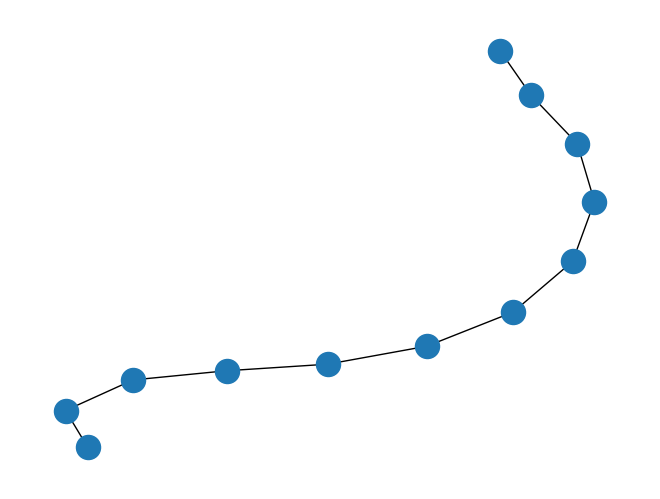

In [11]:
timegraph = build_time_graph(obs_window,True,False)
print(timegraph)
tg = nx.from_numpy_array(timegraph)
nx.draw(tg)

In [12]:
# Normalize the adjacency matrix
S = normalize_adjacency(torch.tensor(adj_mat))
S_t = torch.tensor(timegraph)

In [13]:
print(adj_mat.shape)

(134, 134)


In [14]:
pg = build_parametric_product_graph(S_t, S, 0, 1, 1, 1).to(device)
# pg = np.load('pg.npy')
# pg = torch.from_numpy(pg)
print(pg)

tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0417, 0.0417, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0526, 0.0513, 0.0541],
        [0.0000, 0.0000, 0.0000,  ..., 0.0513, 0.0500, 0.0527],
        [0.0000, 0.0000, 0.0000,  ..., 0.0541, 0.0527, 0.0556]],
       dtype=torch.float64)


In [15]:
print(pg.shape)

torch.Size([1608, 1608])


In [59]:
## OLD DONT RUN
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNNLayer(nn.Module):
    def __init__(self, in_features, out_features, matrix_powers, order):
        super(GCNNLayer, self).__init__()
        self.matrix_powers = matrix_powers
        self.order = order
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features, order))
        # use Xavier initialization to match variance of input with output
        nn.init.xavier_uniform_(self.weights)

    def forward(self, features, edge_index=None, index=None):
        batch_size = features.size(0)
        output_dim = self.weights.size(1)
        device = features.device

        out = torch.zeros((batch_size, features.size(1), output_dim), device=device)
        for k in range(self.order):
            weighted = torch.bmm(features, self.weights[:, :, k].unsqueeze(0).repeat(batch_size, 1, 1))
            shifted = torch.bmm(self.matrix_powers[k].unsqueeze(0).repeat(batch_size, 1, 1).to(device), weighted)
            out += shifted
        return out


# Inputs must be sized [num_nodes, obs_size] and outputs will be [num_nodes, pred_size]
class GCNN(nn.Module):
    def __init__(self, hid_sizes, shift, order):
        super(GCNN, self).__init__()
        self.layers = nn.ModuleList()
        # compute matrix shift
        matrix_powers = [torch.matrix_power(shift, k).float() for k in range(order)]
        # input layer of size obs_size
        self.layers.append(GCNNLayer(1, hid_sizes[0], matrix_powers, order))
        # num_hid hidden layers of size hid_size
        for i in range(len(hid_sizes) - 1):
            self.layers.append(GCNNLayer(hid_sizes[i], hid_sizes[i + 1], matrix_powers, order))

    def forward(self, features, edge_index=None, index=None):
        temp = features
        for layer in self.layers[:-1]:
            # use relu activation function
            temp = F.relu(layer(temp))
        return self.layers[-1](temp)

model = GCNN([128,128, 1],pg,1).to(device)

In [60]:

import time

def train_epoch(model, loader, optimizer, device='cpu'):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        print(x.shape)
        outputs = model(x)
        loss = torch.nn.functional.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_epoch(model, loader, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            print(x.shape)
            outputs = model(x)
            loss = torch.nn.functional.mse_loss(outputs, y)
            total_loss += loss.item()
    return total_loss / len(loader)


def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device=device)
        val_loss = evaluate_epoch(model, val_loader, device=device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(f"epoch: {epoch}\ttraining loss: {train_loss:.4f}\tvalidation loss: {val_loss:.4f}")

    elapsed_time = time.time() - start_time
    if device.type == 'cuda':
        torch.cuda.synchronize()
    print(f'Model training took {elapsed_time:.3f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, val_loader)

torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'model.pth')

In [16]:
print(train.shape)
train_reshaped = train.reshape((train.shape[0], train.shape[1], 1))
print(train_reshaped.shape)

(134, 246)
(134, 246, 1)


In [ ]:
## OLD DONT RUN
from torch_geometric.utils import from_networkx

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

data = from_networkx(G)
edge_index = data.edge_index
# edge_index_list = edge_index.tolist()
# edge_index_tensor = torch.tensor(edge_index_list, dtype=torch.long)

print(f"Edge Index Shape: {edge_index.shape}")

node_idx = 3

for x, y in train_loader:
  x, y = x.to(device), y.to(device)
  print(x.shape)
  explanation = explainer(x=x, edge_index=edge_index, index=node_idx)
  break

#explanation = explainer(x=torch.tensor(train_reshaped, dtype=torch.float), edge_index=edge_index_list, index=node_idx)

In [132]:
#RUN THIS 

import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNNLayer(nn.Module):
    def __init__(self, in_features, out_features, matrix_powers, order):
        super(GCNNLayer, self).__init__()
        self.matrix_powers = matrix_powers
        self.order = order
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features, 1))
        # use Xavier initialization to match variance of input with output
        nn.init.xavier_uniform_(self.weights)

    def batch_forward(self, features):
        batch_size = features.size(0)
        output_dim = self.weights.size(1)
        device = features.device
        
        #cute might delete later
        if features.dim() == 2:  # Add singleton dimension if features is 2D
            features = features.unsqueeze(-1)

        # print(f"features shape: {features.shape}")
        # print(f"weights shape: {self.weights.shape}")

        out = torch.zeros((batch_size, features.size(1), output_dim), device=device)
        for k in range(self.order):
            weighted = torch.bmm(features, self.weights[:, :, k].unsqueeze(0).repeat(batch_size, 1, 1))
            shifted = torch.bmm(self.matrix_powers[k].unsqueeze(0).repeat(batch_size, 1, 1).to(device), weighted)
            out += shifted
        return out
    
    def forward(self, features, edge_index=None, index=None, **kwargs):
            #print(f"==================={kwargs}")
            #print("Edge index: ", edge_index)
            expl = kwargs.get('expl', None)
            if expl != True:
                #print("==========BATCH FORWARD=========")
                return self.batch_forward(features) #if we do normal training
            else: #if we got some explaining to do
                output_dim = self.weights.size(1)

                tensor_list = []
                if features.ndim==3:
                    features = features.squeeze(0)
                #print("FEATURES SHAPE:", features.shape)

                #print(f" features(0): {features.size(0)}, output_dim:{output_dim}")
                out = torch.zeros((features.size(0), output_dim), device=features.device)
                for k in range(self.order):
                    weighted_features = torch.matmul(features, self.weights[:, :, k])
                    # shift_k = self.matrix_powers[k]
                    shift_k = torch.tensor(edge_index, dtype=torch.float)
                    shifted_features = torch.matmul(shift_k, weighted_features)
                    #print(f"shifted features:{k}, {shifted_features.shape}")
                    out += shifted_features
                    
                tensor_list.append(out)
                return torch.stack(tensor_list, dim=0)

# Inputs must be sized [num_nodes, obs_size] and outputs will be [num_nodes, pred_size]
class GCNN(nn.Module):
    def __init__(self, hid_sizes, shift, order=1):
        super(GCNN, self).__init__()
        self.order = order  # Set the order as an attribute of the class
        self.layers = nn.ModuleList()
        # compute matrix shift
        matrix_powers = [torch.matrix_power(shift, k).float() for k in range(order)]
        # input layer of size obs_size
        self.layers.append(GCNNLayer(1, hid_sizes[0], matrix_powers, 1))
        # num_hid hidden layers of size hid_size
        for i in range(len(hid_sizes) - 1):
            self.layers.append(GCNNLayer(hid_sizes[i], hid_sizes[i + 1], matrix_powers, 1))

    def forward(self, features, edge_index=None, index=None, **kwargs):
        expl = kwargs.get('expl', None)
        #print("expl", expl) 
        temp = features
        for layer in self.layers[:-1]:
            #print("huh?")
            # use relu activation function
            temp = F.relu(layer(temp, edge_index=edge_index, **kwargs))
        if expl == True:
            temp = self.layers[-1](temp, edge_index=edge_index, **kwargs)
            return temp.squeeze(0)
        return self.layers[-1](temp, edge_index=edge_index, **kwargs)
        
model = GCNN([128,128, 1],pg,1).to(device)


In [133]:

import time

def train_epoch(model, loader, optimizer, device='cpu'):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        print(x.shape)
        outputs = model(x)
        loss = torch.nn.functional.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_epoch(model, loader, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            #print(x.shape)
            outputs = model(x)
            print(f"model output: {outputs.shape}")
            loss = torch.nn.functional.mse_loss(outputs, y)
            total_loss += loss.item()
    return total_loss / len(loader)


def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device=device)
        val_loss = evaluate_epoch(model, val_loader, device=device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(f"epoch: {epoch}\ttraining loss: {train_loss:.4f}\tvalidation loss: {val_loss:.4f}")

    elapsed_time = time.time() - start_time
    if device.type == 'cuda':
        torch.cuda.synchronize()
    print(f'Model training took {elapsed_time:.3f} seconds')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader)

torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch: 1	training loss: 1.7296	validation loss: 0.0722
torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch: 2	training loss: 0.1651	validation loss: 0.0704
torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch: 3	training loss: 0.1275	validation loss: 0.0759
torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch: 4	training loss: 0.1080	validation loss: 0.0633
torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch: 5	training loss: 0.1073	validation loss: 0.0662
torch.Size([100, 1608, 1])
torch.Size([100, 1608, 1])
torch.Size([22, 1608, 1])
model output: torch.Size([12, 1608, 1])
epoch

In [100]:
#RUN THIS 
from torch_geometric.utils import from_networkx
from torch_geometric.utils import dense_to_sparse

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=10),
    explanation_type='model',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

# data = from_networkx(G)
# edge_index = data.edge_index

edge_index = dense_to_sparse(pg)

print("Edge Index:")
print(edge_index[0].shape) 


node_idx = 1600
kwargs = {'expl':True, 'hid_sizes':[128,128, 1]}

#RUN THIS 

for x, y in train_loader:
  x, y = x.to(device), y.to(device)
  for x_single in x:

    print(f"Single shape x: {x_single.shape}")
    explanation = explainer(x=x_single, edge_index=pg, index=node_idx, **kwargs)
    break
  print("pliep")
  break

  #explanation = explainer(x=x_single, edge_index=edge_index[0],index=5, **kwargs)
  #break

#explanation = explainer(x=torch.tensor(train_reshaped, dtype=torch.float), edge_index=edge_index_list, index=node_idx)

Edge Index:
torch.Size([2, 59754])
Single shape x: torch.Size([1608, 1])
Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0417, 0.0417, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0526, 0.0513, 0.0541],
        [0.0000, 0.0000, 0.0000,  ..., 0.0513, 0.0500, 0.0527],
        [0.0000, 0.0000, 0.0000,  ..., 0.0541, 0.0527, 0.0556]],
       dtype=torch.float64)
Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0417, 0.0417, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0526, 0.0513, 0.0541],
        [0.0000, 0.0000, 0.0000,  ..., 0.0513, 0.0500, 0.0527],
        [0.0000, 0.0000, 0.0000,  ..., 0.0541, 0.0527, 0.0556]],
       dtype=torch.float64)
Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..

/var/folders/f9/f489rvfn4hsdfx4c91m6h1b40000gn/T/ipykernel_17322/3489962941.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  shift_k = torch.tensor(edge_index, dtype=torch.float)


Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0417, 0.0417, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0526, 0.0513, 0.0541],
        [0.0000, 0.0000, 0.0000,  ..., 0.0513, 0.0500, 0.0527],
        [0.0000, 0.0000, 0.0000,  ..., 0.0541, 0.0527, 0.0556]],
       dtype=torch.float64)
Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0417, 0.0417, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0526, 0.0513, 0.0541],
        [0.0000, 0.0000, 0.0000,  ..., 0.0513, 0.0500, 0.0527],
        [0.0000, 0.0000, 0.0000,  ..., 0.0541, 0.0527, 0.0556]],
       dtype=torch.float64)
Edge index:  tensor([[0.0400, 0.0400, 0.0417,  ..., 0.0000, 0.0000, 0.0000],
        [0.0400, 0.0400, 0.0417,  ..., 0.0000

In [101]:
print(explanation)
explanation.node_mask.shape
print(explanation.node_mask)


#Explanation(node_mask=[2708, 1433], edge_mask=[10556], prediction=[2708, 7], target=[2708], index=[1], x=[2708, 1433], edge_index=[2, 10556])

Explanation(node_mask=[1608, 1], prediction=[1608, 1], target=[1608, 1], index=[1], x=[1608, 1], edge_index=[1608, 1608], expl=True, hid_sizes=[3])
tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.4818],
        [0.4860],
        [0.4979]])


In [102]:
# Assuming 'explanation' contains the tensor data you want to save
tensor_data = explanation.node_mask.tolist()  # Convert tensor to list

# Define the file path where you want to save the CSV
csv_file = f'explanation_data_{node_idx}.csv'

# Write the data to CSV
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(tensor_data)

print(f"Data saved to {csv_file}")

Data saved to explanation_data_1600.csv


In [135]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100), #set back to 100 when it works
    explanation_type='model',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

node_idx = 1600
kwargs = {'expl':True}

#RUN THIS 

for x, y in train_loader:
  x, y = x.to(device), y.to(device)
  for x_single in x:
    x_first = x_single
    break
  break

total_explanations = []
for node_idx in range(1608):
    print(node_idx)
    explanation = explainer(x=x_first, edge_index=pg, index=node_idx, **kwargs)
    node_explanation = explanation.node_mask.T.numpy()
    #print(node_explanation.shape)
    #print("node explanation: ", node_explanation.shape)
    total_explanations.append(node_explanation)

combined_explanations = np.vstack(total_explanations)
print(combined_explanations.shape)

csv_file = f'total_explanation_data_EPOCH100.csv'

# Write the data to CSV
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(combined_explanations)

print(f"Data saved to {csv_file}")
    


0


/var/folders/f9/f489rvfn4hsdfx4c91m6h1b40000gn/T/ipykernel_17322/2532799843.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  shift_k = torch.tensor(edge_index, dtype=torch.float)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [103]:
# Assuming explanation is obtained from your explainer
node_mask = explanation.node_mask

# Extracting importance scores for node 3
node_importance = node_mask[:, 0]  # Extracting the single importance score for each batch

# Determine which nodes have impact on node 3
threshold = 0.0  # Adjust as needed based on the scale of importance scores
impacted_nodes = []

for i, importance_score in enumerate(node_importance):
    if importance_score > threshold:
        impacted_nodes.append(i)

# impacted_nodes now contains indices of batches where node 3 is impacted

print(f"Nodes impacting node 3 with importance score above {threshold}: {impacted_nodes}")

print("total impacted nodes: ", len(impacted_nodes))

Nodes impacting node 3 with importance score above 0.0: [1072, 1073, 1074, 1075, 1076, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1132, 1133, 1134, 1135, 1136, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1266, 1267, 1268, 1269, 1270, 1271, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1

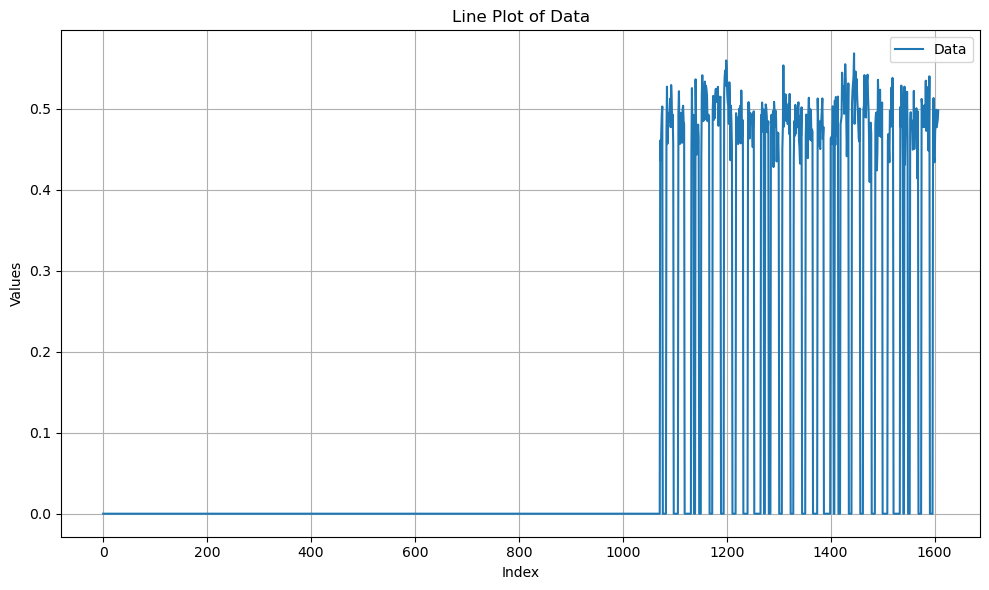

In [104]:
import matplotlib.pyplot as plt

# Generate some sample data (replace with your actual data)
x = np.arange(1608)  # Generate x values from 0 to 1607
y = node_importance  # Replace with your actual data array

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(x, y, label='Data')
plt.title('Line Plot of Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

0       135.131321
1       134.846713
2       159.919514
3       142.079044
4       145.410084
           ...    
1603     51.687877
1604     52.835402
1605     54.111822
1606     54.524764
1607     53.070766
Length: 1608, dtype: float64
[('1.0', {'pos': [3349.8515, 5939.23193]}), ('2.0', {'pos': [3351.0017, 6416.64673]}), ('3.0', {'pos': [3314.7797, 6892.18395]}), ('4.0', {'pos': [3352.094, 7366.14203]}), ('5.0', {'pos': [3355.342, 7841.20175]}), ('6.0', {'pos': [3329.4284, 8340.79769]}), ('7.0', {'pos': [3360.5473, 8816.23834]}), ('8.0', {'pos': [3360.2992, 9265.21442]}), ('9.0', {'pos': [3359.9419, 10696.54549]}), ('10.0', {'pos': [3361.2616, 11171.77916]}), ('11.0', {'pos': [3244.0619, 11646.05877]}), ('12.0', {'pos': [3286.7788, 12121.00426]}), ('13.0', {'pos': [3326.2552, 244.02595]}), ('14.0', {'pos': [3328.7796, 719.04816]}), ('15.0', {'pos': [3329.7588, 1194.28795]}), ('16.0', {'pos': [3333.9042, 1658.25733]}), ('17.0', {'pos': [3334.2558, 2140.55426]}), ('18.0', {'pos': [3336

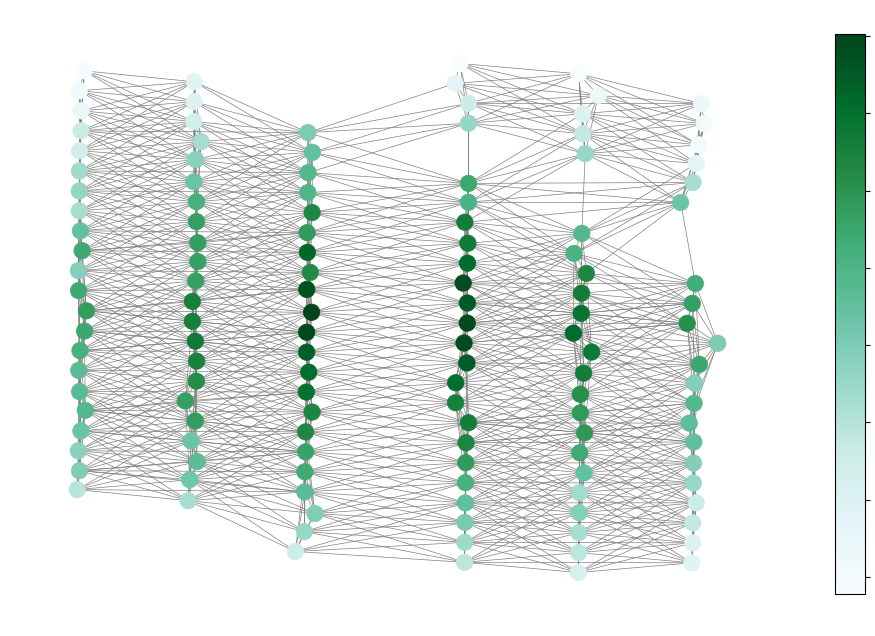

In [233]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Read the CSV file
file_path = 'total_explanation_data_EPOCH100.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path, header=None)

# Sum each column (axis=0) to get a single row
sum_row = data.sum(axis=0)

# Display the summed row
print(sum_row)

importance_scores_turbines = np.zeros(134)
for w in range(134):
    for t in range(12):
        product_graph_index = w + (134 * t)
        importance_scores_turbines[w] += sum_row[product_graph_index]
        # if w == 40:
        #     print(f"{importance_scores_turbines[w]} \t \t { sum_row[product_graph_index]}")

G = nx.read_gml('data/spatial_graph_2000.gml')
print(G.nodes(data=True))


for i, node in enumerate(G.nodes()):
    G.nodes[node]['importance'] = importance_scores_turbines[i]

print(G.nodes(data=True))
# Visualize the graph
fig, ax = plt.subplots(figsize=(10, 8))

# Position nodes based on 'pos' attribute
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}

# Calculate node colors based on 'importance' scores
importance_values = [G.nodes[node]['importance'] for node in G.nodes()]

cmap = plt.cm.BuGn  # Choose a colormap
norm = plt.Normalize(vmin=min(importance_values), vmax=max(importance_values))
colors = [cmap(norm(G.nodes[node]['importance'])) for node in G.nodes()]

# Draw nodes with sizes based on values
nx.draw(G, pos, node_size=140, node_color=colors, with_labels=False, edge_color='grey',width=0.5, linewidths=0.50, font_size=10, ax=ax)

# Create a separate axis for the color bar
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  # Adjust the position and size of the color bar
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')
cbar_ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

plt.title("Influential nodes in turbine network using GNNExplainer")
plt.show()

In [229]:
#Single node explainer

file_path = 'total_explanation_data_EPOCH100.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path, header=None)

node_idx = 120

indices = [node_idx + 134 * i for i in range(12)]

selected_rows = data.iloc[indices]
print(selected_rows)

# Sum the columns of the selected rows
sum_row = selected_rows.sum(axis=0)

# Display the summed row
print("sum_row",sum_row)


importance_scores_turbines = np.zeros(134)

for w in range(134):
     for t in range(12):
         product_graph_index = w + (134 * t)
         importance_scores_turbines[w] += sum_row[product_graph_index]
         print(f"{importance_scores_turbines[w]} \t \t { sum_row[product_graph_index]}")




      0         1         2         3         4         5         6     \
120    0.0  0.259085  0.278107  0.291875  0.272645  0.306284  0.289498   
254    0.0  0.291447  0.288441  0.259304  0.297470  0.269266  0.262485   
388    0.0  0.257897  0.289453  0.294534  0.280534  0.266742  0.273875   
522    0.0  0.272385  0.261321  0.306345  0.298328  0.300327  0.289040   
656    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
790    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
924    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1058   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1192   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1326   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1460   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1594   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9     .

[('1.0', {'pos': [3349.8515, 5939.23193]}), ('2.0', {'pos': [3351.0017, 6416.64673]}), ('3.0', {'pos': [3314.7797, 6892.18395]}), ('4.0', {'pos': [3352.094, 7366.14203]}), ('5.0', {'pos': [3355.342, 7841.20175]}), ('6.0', {'pos': [3329.4284, 8340.79769]}), ('7.0', {'pos': [3360.5473, 8816.23834]}), ('8.0', {'pos': [3360.2992, 9265.21442]}), ('9.0', {'pos': [3359.9419, 10696.54549]}), ('10.0', {'pos': [3361.2616, 11171.77916]}), ('11.0', {'pos': [3244.0619, 11646.05877]}), ('12.0', {'pos': [3286.7788, 12121.00426]}), ('13.0', {'pos': [3326.2552, 244.02595]}), ('14.0', {'pos': [3328.7796, 719.04816]}), ('15.0', {'pos': [3329.7588, 1194.28795]}), ('16.0', {'pos': [3333.9042, 1658.25733]}), ('17.0', {'pos': [3334.2558, 2140.55426]}), ('18.0', {'pos': [3336.8477, 2615.58831]}), ('19.0', {'pos': [3338.8861, 3090.44941]}), ('20.0', {'pos': [3361.0339, 3566.91886]}), ('21.0', {'pos': [3249.0218, 4043.58605]}), ('22.0', {'pos': [3250.8602, 4519.34673]}), ('23.0', {'pos': [3346.8376, 4989.86182]

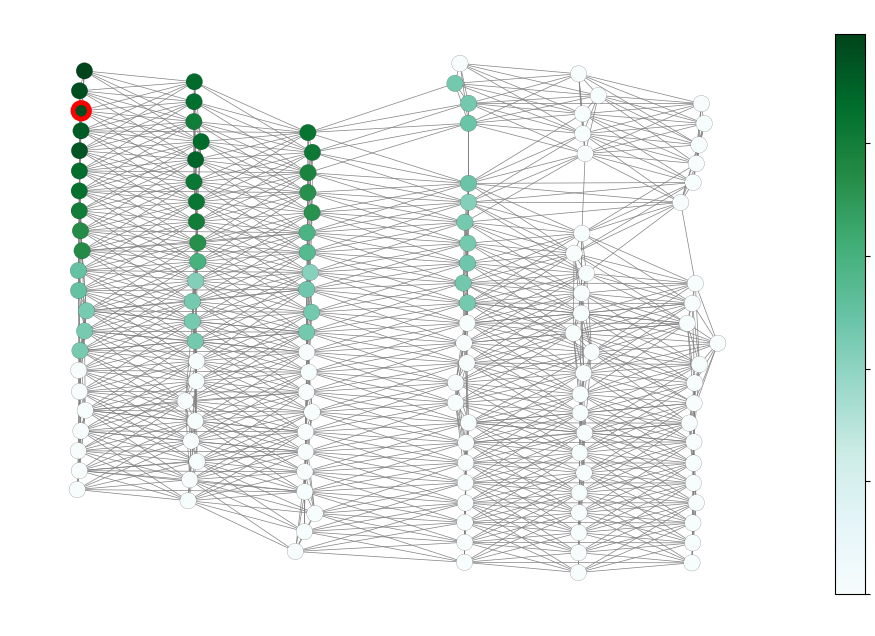

In [232]:
G = nx.read_gml('data/spatial_graph_2000.gml')
print(G.nodes(data=True))


for i, node in enumerate(G.nodes()):
    G.nodes[node]['importance'] = importance_scores_turbines[i]

print(G.nodes(data=True))
# Visualize the graph
fig, ax = plt.subplots(figsize=(10, 8))

# Position nodes based on 'pos' attribute
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}

# Calculate node colors based on 'importance' scores
importance_values = [G.nodes[node]['importance'] for node in G.nodes()]

cmap = plt.cm.BuGn  # Choose a colormap
norm = plt.Normalize(vmin=min(importance_values), vmax=max(importance_values))
colors = [cmap(norm(G.nodes[node]['importance'])) for node in G.nodes()]

node_border_colors = ['black' for _ in G.nodes()]
node_border_widths = [0.1 for _ in G.nodes()]
print(node_border_colors)

node_border_colors[node_idx] = 'red'
node_border_widths[node_idx] = 3.5
print(node_border_colors)

# Draw nodes with sizes based on values
nx.draw(G, pos, node_size=140, node_color=colors, with_labels=False,edgecolors=node_border_colors, edge_color='grey',width=0.5, linewidths=node_border_widths, font_size=10, ax=ax)

# Create a separate axis for the color bar
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  # Adjust the position and size of the color bar
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')
cbar_ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

plt.show()

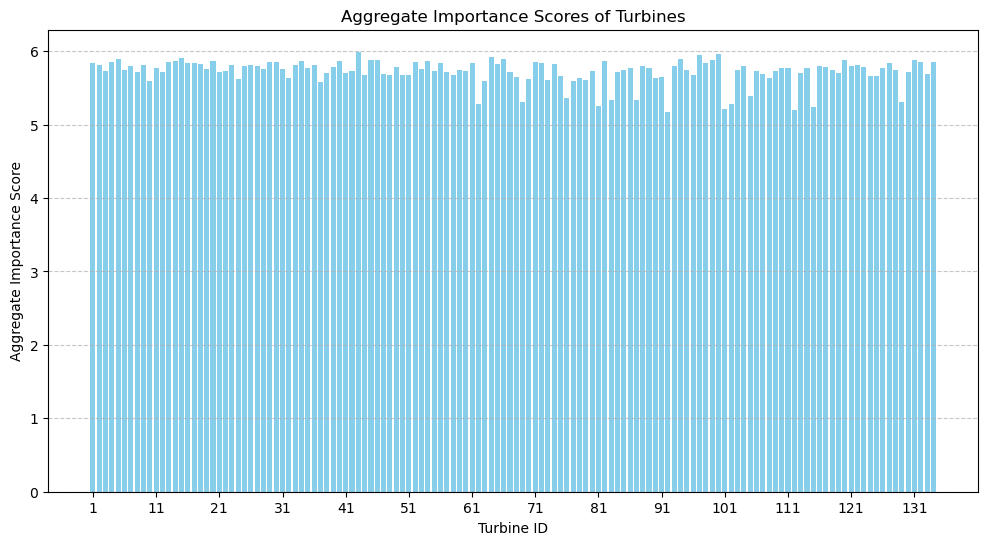

In [78]:



# Example importance scores for the product graph (1608 nodes)
# Replace with your actual importance scores from GNNexplainer
importance_scores_product_graph = node_importance

# Assume you have a function to map from (turbine_index, timestep_index) to product graph node index
def node_index(turbine_index, timestep_index):
    return turbine_index * 12 + timestep_index

# Aggregate importance scores for each turbine
turbine_ids = range(1, 135)
importance_scores_turbines = np.zeros(134)  # Initialize array for aggregate scores

for t in range(134):
    for s in range(12):
        product_graph_index = node_index(t, s)
        importance_scores_turbines[t] += importance_scores_product_graph[product_graph_index]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(turbine_ids, importance_scores_turbines, color='skyblue')
plt.xlabel('Turbine ID')
plt.ylabel('Aggregate Importance Score')
plt.title('Aggregate Importance Scores of Turbines')
plt.xticks(ticks=range(1, 135, 10))  # Adjust ticks as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()